## parsing

In [ ]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
import urllib.parse
from sklearn import tree
from sklearn import metrics
import io
from sklearn.svm import LinearSVC
from sklearn.metrics import confusion_matrix

import pandas as pd


In [ ]:
normal_file_raw = 'normalTrafficTraining.txt'
anomaly_file_raw = 'anomalousTrafficTest.txt'

normal_file_parse = 'normalRequestTraining.txt'
anomaly_file_parse = 'anomalousRequestTest.txt'

In [ ]:
def parse_file(file_in, file_out):
    fin = open(file_in)
    fout = io.open(file_out, "w", encoding="utf-8")
    lines = fin.readlines()
    res = []
    for i in range(len(lines)):
        line = lines[i].strip()
        if line.startswith("GET"):
            res.append("GET" + line.split(" ")[1])
        elif line.startswith("POST") or line.startswith("PUT"):
            url = line.split(' ')[0] + line.split(' ')[1]
            j = 1
            while True:
                if lines[i + j].startswith("Content-Length"):
                    break
                j += 1
            j += 1
            data = lines[i + j + 1].strip()
            url += '?' + data
            res.append(url)
    for line in res:
        line = urllib.parse.unquote(line).replace('\n','').lower()
        fout.writelines(line + '\n')
    print ("finished parse ",len(res)," requests")
    fout.close()
    fin.close()

def loadData(file):
    with open(file, 'r', encoding="utf8") as f:
        data = f.readlines()
    result = []
    for d in data:
        d = d.strip()
        if (len(d) > 0):
            result.append(d)
    return result

In [ ]:
parse_file(normal_file_raw,normal_file_parse)
parse_file(anomaly_file_raw,anomaly_file_parse)

## Load data

In [ ]:
bad_requests = loadData('anomalousRequestTest.txt')
good_requests = loadData('normalRequestTraining.txt')

all_requests = bad_requests + good_requests
yBad = [1] * len(bad_requests)
yGood = [0] * len(good_requests)
y = yBad + yGood

In [ ]:
type(y)

list

In [ ]:
len(y)

97065

In [ ]:
malicious_urls = bad_requests
normal_urls = good_requests
data = pd.DataFrame({'URL': malicious_urls + normal_urls, 'Label': [1] * len(malicious_urls) + [0] * len(normal_urls)})

In [ ]:
import re
data['URL Length'] = data['URL'].apply(len)
data['Question Mark Count'] = data['URL'].apply(lambda x: x.count('?'))
data['Special Char Count'] = data['URL'].apply(lambda x: sum(c.isalnum() for c in x))
data['Digit Count'] = data['URL'].apply(lambda x: sum(c.isdigit() for c in x))
data['Slash Count'] = data['URL'].apply(lambda x: x.count('/'))
data['Contains IP'] = data['URL'].apply(lambda x: bool(re.search(r'\d{1,3}\.\d{1,3}\.\d{1,3}\.\d{1,3}', x)))
data['Subdomain Count'] = data['URL'].apply(lambda x: len(x.split('.')) - 2)
data['Uses HTTPS'] = data['URL'].apply(lambda x: x.startswith('https://'))
data['Has TLD'] = data['URL'].apply(lambda x: x.endswith(('.com', '.org', '.net')))

In [ ]:
data = data[['URL', 'URL Length', 'Question Mark Count',
       'Special Char Count', 'Digit Count', 'Slash Count', 'Contains IP',
       'Subdomain Count', 'Uses HTTPS', 'Has TLD', 'Label']]

In [ ]:
data

,URL,URL Length,Question Mark Count,Special Char Count,Digit Count,Slash Count,Contains IP,Subdomain Count,Uses HTTPS,Has TLD,Label
0,gethttp://localhost:8080/tienda1/publico/anadi...,182,1,141,9,5,False,0,False,False,1
1,posthttp://localhost:8080/tienda1/publico/anad...,183,1,142,9,5,False,0,False,False,1
2,gethttp://localhost:8080/tienda1/publico/anadi...,121,1,96,11,6,False,0,False,False,1
3,posthttp://localhost:8080/tienda1/publico/anad...,122,1,97,11,6,False,0,False,False,1
4,gethttp://localhost:8080/asf-logo-wide.gif~,43,0,34,4,3,False,0,False,False,1
...,...,...,...,...,...,...,...,...,...,...,...
97060,gethttp://localhost:8080/tienda1/imagenes/2.gif,47,0,39,6,5,False,0,False,False,0
97061,gethttp://localhost:8080/tienda1/imagenes/3.gif,47,0,39,6,5,False,0,False,False,0
97062,gethttp://localhost:8080/tienda1/imagenes/cmen...,53,0,45,5,5,False,0,False,False,0
97063,gethttp://localhost:8080/tienda1/imagenes/logo...,50,0,42,5,5,False,0,False,False,0


In [ ]:
data['Label'].value_counts()

0    72000
1    25065
Name: Label, dtype: int64

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 97065 entries, 0 to 97064
Data columns (total 11 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   URL                  97065 non-null  object
 1   URL Length           97065 non-null  int64 
 2   Question Mark Count  97065 non-null  int64 
 3   Special Char Count   97065 non-null  int64 
 4   Digit Count          97065 non-null  int64 
 5   Slash Count          97065 non-null  int64 
 6   Contains IP          97065 non-null  bool  
 7   Subdomain Count      97065 non-null  int64 
 8   Uses HTTPS           97065 non-null  bool  
 9   Has TLD              97065 non-null  bool  
 10  Label                97065 non-null  int64 
dtypes: bool(3), int64(7), object(1)
memory usage: 6.2+ MB


In [ ]:
data.isnull().sum()

URL                    0
URL Length             0
Question Mark Count    0
Special Char Count     0
Digit Count            0
Slash Count            0
Contains IP            0
Subdomain Count        0
Uses HTTPS             0
Has TLD                0
Label                  0
dtype: int64

In [ ]:
malicious_lengths = [len(url) for url in bad_requests]
normal_lengths = [len(url) for url in good_requests]

print("Malicious URL Lengths:", malicious_lengths)
print("Normal URL Lengths:", normal_lengths)

print('max --- ')
print(max(malicious_lengths))
print(max(normal_lengths))
print('min --- ')
print(min(malicious_lengths))
print(min(normal_lengths))
print('avg --- ')
print(sum(malicious_lengths)/len(malicious_lengths))
print(sum(normal_lengths)/len(normal_lengths))

Malicious URL Lengths: [182, 183, 121, 122, 43, 158, 159, 119, 120, 119, 120, 66, 67, 62, 63, 86, 87, 81, 129, 130, 94, 95, 94, 95, 298, 350, 351, 344, 345, 300, 301, 299, 300, 42, 70, 71, 70, 71, 69, 37, 43, 54, 83, 52, 55, 411, 412, 271, 272, 282, 283, 278, 279, 44, 52, 166, 167, 120, 121, 120, 121, 54, 119, 175, 176, 121, 122, 120, 121, 52, 65, 67, 68, 66, 67, 64, 46, 149, 150, 87, 88, 86, 87, 57, 43, 142, 143, 90, 91, 95, 96, 64, 328, 329, 298, 299, 293, 294, 119, 120, 70, 71, 77, 64, 319, 320, 279, 280, 281, 282, 63, 43, 51, 49, 54, 177, 178, 120, 121, 116, 117, 116, 117, 68, 69, 66, 67, 61, 112, 113, 86, 87, 94, 95, 94, 95, 303, 304, 285, 286, 292, 293, 43, 130, 131, 70, 71, 28, 71, 46, 55, 89, 75, 299, 300, 301, 302, 46, 58, 74, 65, 51, 57, 123, 124, 123, 124, 176, 177, 114, 115, 113, 114, 66, 67, 52, 64, 65, 86, 87, 55, 72, 94, 95, 94, 95, 82, 285, 287, 288, 53, 106, 107, 70, 71, 55, 43, 75, 283, 284, 284, 285, 28, 120, 121, 121, 122, 122, 123, 117, 118, 117, 118, 105, 106, 66,

## Preprocessing

In [ ]:
df = data

In [ ]:
data.columns

Index(['URL', 'URL Length', 'Question Mark Count', 'Special Char Count',
       'Digit Count', 'Slash Count', 'Contains IP', 'Subdomain Count',
       'Uses HTTPS', 'Has TLD', 'Label'],
      dtype='object')

In [ ]:
features = data[['URL Length', 'Question Mark Count', 'Special Char Count',
       'Digit Count', 'Slash Count', 'Contains IP', 'Subdomain Count',
       'Uses HTTPS', 'Has TLD',]]

In [ ]:
data[data['URL Length'] > 600]

,URL,URL Length,Question Mark Count,Special Char Count,Digit Count,Slash Count,Contains IP,Subdomain Count,Uses HTTPS,Has TLD,Label
983,gethttp://localhost:8080/tienda1/publico/regis...,627,2,473,217,5,False,1,False,False,1
984,posthttp://localhost:8080/tienda1/publico/regi...,628,2,474,217,5,False,1,False,False,1
1293,gethttp://localhost:8080/tienda1/publico/regis...,652,2,493,215,5,False,1,False,False,1
1294,posthttp://localhost:8080/tienda1/publico/regi...,653,2,494,215,5,False,1,False,False,1
1500,gethttp://localhost:8080/tienda1/publico/regis...,665,2,508,221,5,False,1,False,False,1
1501,posthttp://localhost:8080/tienda1/publico/regi...,666,2,509,221,5,False,1,False,False,1
1910,gethttp://localhost:8080/tienda1/publico/regis...,649,2,493,219,5,False,1,False,False,1
1911,posthttp://localhost:8080/tienda1/publico/regi...,650,2,494,219,5,False,1,False,False,1
2085,gethttp://localhost:8080/tienda1/miembros/edit...,615,2,462,218,5,False,2,False,False,1
2086,posthttp://localhost:8080/tienda1/miembros/edi...,616,2,463,218,5,False,2,False,False,1


In [ ]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.preprocessing import StandardScaler
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
import numpy as np

# Tokenization
tokenizer = Tokenizer()
tokenizer.fit_on_texts(df['URL'])
sequences = tokenizer.texts_to_sequences(df['URL'])

# Sequence Padding
max_sequence_length = 666
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Vectorization - Count Vectorization
count_vectorizer = CountVectorizer()
count_vectorized_data = count_vectorizer.fit_transform(df['URL'])

# Vectorization - TF-IDF Vectorization
tfidf_vectorizer = TfidfVectorizer()
tfidf_vectorized_data = tfidf_vectorizer.fit_transform(df['URL'])

# Standard Scaling (Assuming 'Label' is the target variable)
standard_scaler = StandardScaler()
scaled_features = standard_scaler.fit_transform(features)

X = np.hstack((scaled_features, padded_sequences))
X = X.reshape(X.shape[0], 1, X.shape[1])

# Splitting the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(
    X, df['Label'], test_size=0.2, random_state=42
)

# Example: Display the shape of the preprocessed data
print("Padded Sequences Shape:", padded_sequences.shape)
print("Count Vectorized Data Shape:", count_vectorized_data.shape)
print("TF-IDF Vectorized Data Shape:", tfidf_vectorized_data.shape)
print("Scaled Features Shape:", scaled_features.shape)
print("X_train Shape:", X_train.shape)
print("X_test Shape:", X_test.shape)
print("y_train Shape:", y_train.shape)
print("y_test Shape:", y_test.shape)

Padded Sequences Shape: (97065, 666)
Count Vectorized Data Shape: (97065, 48668)
TF-IDF Vectorized Data Shape: (97065, 48668)
Scaled Features Shape: (97065, 9)
X_train Shape: (77652, 1, 675)
X_test Shape: (19413, 1, 675)
y_train Shape: (77652,)
y_test Shape: (19413,)


# Tensorflow

## LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, LSTM, Bidirectional, Dense, Dropout
from keras.optimizers import Adam


In [ ]:
import tensorflow as tf
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    min_delta=0.001,
    patience=20,
    verbose=1,
    mode='auto',
    baseline=None,
    restore_best_weights=False,
    start_from_epoch=0
)

In [ ]:
model = Sequential()
model.add(LSTM(units=50, activation='relu', return_sequences=True))
# model.add(Dropout(0.1))  # Example dropout layer
model.add(LSTM(units=50, activation='relu'))
# model.add(Dense(units=10, activation='relu'))
model.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate
model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

import time

start_time = time.time()
model.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2,callbacks = early_stopping)
end_time = time.time()

training_time_tensorflow = end_time - start_time



Epoch 1/50
113/113 [==============================] - 10s 32ms/step - loss: 7.2705 - accuracy: 0.7782 - val_loss: 3.3397 - val_accuracy: 0.8384
Epoch 2/50
113/113 [==============================] - 3s 25ms/step - loss: 2.6041 - accuracy: 0.8306 - val_loss: 2.2313 - val_accuracy: 0.8179
Epoch 3/50
113/113 [==============================] - 3s 24ms/step - loss: 1.4055 - accuracy: 0.8511 - val_loss: 1.1927 - val_accuracy: 0.8381
Epoch 4/50
113/113 [==============================] - 4s 31ms/step - loss: 1.0164 - accuracy: 0.8605 - val_loss: 1.0296 - val_accuracy: 0.8717
Epoch 5/50
113/113 [==============================] - 2s 19ms/step - loss: 0.6996 - accuracy: 0.8725 - val_loss: 0.8051 - val_accuracy: 0.8768
Epoch 6/50
113/113 [==============================] - 1s 12ms/step - loss: 0.5562 - accuracy: 0.8798 - val_loss: 0.5814 - val_accuracy: 0.8759
Epoch 7/50
113/113 [==============================] - 1s 12ms/step - loss: 0.4154 - accuracy: 0.8982 - val_loss: 0.4821 - val_accuracy: 0.902

In [ ]:
training_time_tensorflow

148.62451648712158

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test)
print(f'Test Loss: {loss:.4f}, Test Accuracy: {accuracy:.4f}')

282/282 [==============================] - 1s 5ms/step - loss: 0.1429 - accuracy: 0.9547
Test Loss: 0.1429, Test Accuracy: 0.9547


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Evaluate the model
import time

start_time = time.time()
outputs_test_tf_lstm = model.predict(X_test)
y_pred_tf_lstm = (outputs_test_tf_lstm > 0.5).astype(int)
end_time = time.time()

prediction_time_tensorflow = end_time - start_time



# Calculate metrics
accuracy_tf_lstm = accuracy_score(y_test, y_pred_tf_lstm)
precision_tf_lstm = precision_score(y_test, y_pred_tf_lstm)
recall_tf_lstm = recall_score(y_test, y_pred_tf_lstm)
f1_tf_lstm = f1_score(y_test, y_pred_tf_lstm)
confusion_mat_tf_lstm = confusion_matrix(y_test, y_pred_tf_lstm)
roc_auc_tf_lstm = roc_auc_score(y_test, outputs_test_tf_lstm)

# Print the metrics
print(f"Accuracy for TensorFlow LSTM: {accuracy_tf_lstm * 100:.2f}%")
print(f"Precision for TensorFlow LSTM: {precision_tf_lstm:.4f}")
print(f"Recall for TensorFlow LSTM: {recall_tf_lstm:.4f}")
print(f"F1 Score for TensorFlow LSTM: {f1_tf_lstm:.4f}")
print(f"ROC-AUC for TensorFlow LSTM: {roc_auc_tf_lstm:.4f}")

282/282 [==============================] - 2s 3ms/step
Accuracy for TensorFlow LSTM: 95.47%
Precision for TensorFlow LSTM: 0.9383
Recall for TensorFlow LSTM: 0.9675
F1 Score for TensorFlow LSTM: 0.9526
ROC-AUC for TensorFlow LSTM: 0.9882


In [ ]:
prediction_time_tensorflow

2.149256706237793

In [ ]:
print("Confusion Matrix for TensorFlow LSTM:")
print(confusion_mat_tf_lstm)

Confusion Matrix for TensorFlow LSTM:
[[4490  270]
 [ 138 4103]]


In [ ]:
import os
from tensorflow.keras.models import load_model

# Assuming model is your trained TensorFlow model
model.save('tensorflow_model.h5')

tensorflow_model_size = os.path.getsize('tensorflow_model.h5') / 1024

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tensorflow_model_size

1981.0390625

## bidirectional LSTM

In [ ]:
model1 = Sequential()
model1.add(Bidirectional(LSTM(units=50, activation='relu', return_sequences=True)))
# model.add(Dropout(0.1))  # Example dropout layer
model1.add(Bidirectional(LSTM(units=50, activation='relu')))
# model.add(Dense(units=10, activation='relu'))
model1.add(Dense(units=1, activation='sigmoid'))

optimizer = Adam(learning_rate=0.001)  # Adjust the learning rate
model1.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
import time

start_time = time.time()
model1.fit(X_train, y_train, epochs=50, batch_size=256, validation_split=0.2,callbacks = early_stopping)
end_time = time.time()

training_time_tensorflow = end_time - start_time

Epoch 1/50
113/113 [==============================] - 9s 27ms/step - loss: 8.1953 - accuracy: 0.7979 - val_loss: 4.7832 - val_accuracy: 0.8549
Epoch 2/50
113/113 [==============================] - 3s 26ms/step - loss: 2.9861 - accuracy: 0.8452 - val_loss: 2.1426 - val_accuracy: 0.8425
Epoch 3/50
113/113 [==============================] - 3s 24ms/step - loss: 1.2412 - accuracy: 0.8612 - val_loss: 1.0385 - val_accuracy: 0.8575
Epoch 4/50
113/113 [==============================] - 2s 21ms/step - loss: 0.6718 - accuracy: 0.8709 - val_loss: 0.6379 - val_accuracy: 0.8702
Epoch 5/50
113/113 [==============================] - 2s 21ms/step - loss: 0.4001 - accuracy: 0.8899 - val_loss: 0.3857 - val_accuracy: 0.8797
Epoch 6/50
113/113 [==============================] - 3s 23ms/step - loss: 0.3190 - accuracy: 0.9014 - val_loss: 0.3548 - val_accuracy: 0.8946
Epoch 7/50
113/113 [==============================] - 4s 36ms/step - loss: 0.2784 - accuracy: 0.9084 - val_loss: 0.2958 - val_accuracy: 0.9106

In [ ]:
training_time_tensorflow

208.00319457054138

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Evaluate the model
import time

start_time = time.time()
outputs_test_tf_bidirectional_lstm = model1.predict(X_test)
y_pred_tf_bidirectional_lstm = (outputs_test_tf_bidirectional_lstm > 0.5).astype(int)
end_time = time.time()

prediction_time_tensorflow = end_time - start_time



# Calculate metrics
accuracy_tf_bidirectional_lstm = accuracy_score(y_test, y_pred_tf_bidirectional_lstm)
precision_tf_bidirectional_lstm = precision_score(y_test, y_pred_tf_bidirectional_lstm)
recall_tf_bidirectional_lstm = recall_score(y_test, y_pred_tf_bidirectional_lstm)
f1_tf_bidirectional_lstm = f1_score(y_test, y_pred_tf_bidirectional_lstm)
confusion_mat_tf_bidirectional_lstm = confusion_matrix(y_test, y_pred_tf_bidirectional_lstm)
roc_auc_tf_bidirectional_lstm = roc_auc_score(y_test, outputs_test_tf_bidirectional_lstm)

# Print the metrics
print(f"Accuracy for TensorFlow Bidirectional LSTM: {accuracy_tf_bidirectional_lstm * 100:.2f}%")
print(f"Precision for TensorFlow Bidirectional LSTM: {precision_tf_bidirectional_lstm:.4f}")
print(f"Recall for TensorFlow Bidirectional LSTM: {recall_tf_bidirectional_lstm:.4f}")
print(f"F1 Score for TensorFlow Bidirectional LSTM: {f1_tf_bidirectional_lstm:.4f}")
print(f"ROC-AUC for TensorFlow Bidirectional LSTM: {roc_auc_tf_bidirectional_lstm:.4f}")

282/282 [==============================] - 1s 3ms/step
Accuracy for TensorFlow Bidirectional LSTM: 97.90%
Precision for TensorFlow Bidirectional LSTM: 0.9756
Recall for TensorFlow Bidirectional LSTM: 0.9800
F1 Score for TensorFlow Bidirectional LSTM: 0.9778
ROC-AUC for TensorFlow Bidirectional LSTM: 0.9939


In [ ]:
prediction_time_tensorflow

1.5285885334014893

In [ ]:
print("Confusion Matrix for TensorFlow Bidirectional LSTM:")
print(confusion_mat_tf_bidirectional_lstm)

Confusion Matrix for TensorFlow Bidirectional LSTM:
[[4656  104]
 [  85 4156]]


In [ ]:
import os
from tensorflow.keras.models import load_model

# Assuming model is your trained TensorFlow model
model1.save('tensorflow_model.h5')

tensorflow_model_size = os.path.getsize('tensorflow_model.h5') / 1024


/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [ ]:
tensorflow_model_size

4178.3359375

# Pytorch

## LSTM

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset

# Tokenization and Sequence Padding (similar to TensorFlow)
tokenizer = Tokenizer()
tokenizer.fit_on_texts(data['URL'])
sequences = tokenizer.texts_to_sequences(data['URL'])
max_sequence_length = 666
padded_sequences = pad_sequences(sequences, maxlen=max_sequence_length, padding='post', truncating='post')

# Standard Scaling (Assuming 'Label' is the target variable)
standard_scaler = StandardScaler()
scaled_features = standard_scaler.fit_transform(features)

# Combine features and sequences
X = np.hstack((scaled_features, padded_sequences))
X = X.reshape(X.shape[0], 1, X.shape[1])

# Convert data to PyTorch tensors
X_tensor = torch.Tensor(X)
y_tensor = torch.Tensor(df['Label'].values)

In [ ]:
# Define the LSTM model in PyTorch
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(LSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size)
        self.relu = nn.ReLU()
        self.lstm2 = nn.LSTM(input_size=hidden_size, hidden_size=hidden_size)
        self.fc = nn.Linear(hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.relu(x)
        x, _ = self.lstm2(x)
        x = self.relu(x)
        x = self.fc(x[:, -1, :])  # Taking the last time step's output
        x = self.sigmoid(x)
        return x

# Instantiate the model
input_size = X.shape[2]
hidden_size = 50
output_size = 1
model_lstm_pt = LSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Define loss and optimizer
criterion_lstm_pt = nn.BCELoss()
optimizer_lstm_pt = optim.Adam(model_lstm_pt.parameters(), lr=0.001)

# Convert data to PyTorch DataLoader
train_dataset_lstm = TensorDataset(X_tensor, y_tensor)
train_loader_lstm = DataLoader(train_dataset_lstm, batch_size=512, shuffle=True)

In [ ]:
import time

start_time = time.time()
# Train the model
num_epochs_lstm_pt = 50
for epoch in range(num_epochs_lstm_pt):
    for inputs, labels in train_loader_lstm:
        optimizer_lstm_pt.zero_grad()
        outputs_lstm_pt = model_lstm_pt(inputs)
        loss_lstm_pt = criterion_lstm_pt(outputs_lstm_pt, labels.view(-1, 1))
        loss_lstm_pt.backward()
        optimizer_lstm_pt.step()
    print(f'Epoch {epoch + 1}/{num_epochs_lstm_pt}, Loss: {loss_lstm_pt.item()}')
end_time = time.time()

training_time_pytorch = end_time - start_time

Epoch 1/50, Loss: 0.41510438919067383
Epoch 2/50, Loss: 0.3326486647129059
Epoch 3/50, Loss: 0.2961350083351135
Epoch 4/50, Loss: 0.2703952193260193
Epoch 5/50, Loss: 0.22807691991329193
Epoch 6/50, Loss: 0.2382073849439621
Epoch 7/50, Loss: 0.23917873203754425
Epoch 8/50, Loss: 0.2178768515586853
Epoch 9/50, Loss: 0.24902349710464478
Epoch 10/50, Loss: 0.19088515639305115
Epoch 11/50, Loss: 0.2673960328102112
Epoch 12/50, Loss: 0.15304385125637054
Epoch 13/50, Loss: 0.2093627154827118
Epoch 14/50, Loss: 0.17754875123500824
Epoch 15/50, Loss: 0.14051304757595062
Epoch 16/50, Loss: 0.19713537395000458
Epoch 17/50, Loss: 0.16148558259010315
Epoch 18/50, Loss: 0.18824471533298492
Epoch 19/50, Loss: 0.17721712589263916
Epoch 20/50, Loss: 0.19519688189029694
Epoch 21/50, Loss: 0.18938304483890533
Epoch 22/50, Loss: 0.17469124495983124
Epoch 23/50, Loss: 0.18476776778697968
Epoch 24/50, Loss: 0.15393061935901642
Epoch 25/50, Loss: 0.15214060246944427
Epoch 26/50, Loss: 0.18512766063213348
Ep

In [ ]:
training_time_pytorch

164.30045795440674

In [ ]:
from sklearn.metrics import accuracy_score

# Assuming X_test and y_test are the NumPy arrays
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test.values)

import time

start_time = time.time()

with torch.no_grad():
    outputs_test_pt = model_lstm_pt(X_test_tensor)
    y_pred_pt = (outputs_test_pt > 0.5).numpy().astype(int)
end_time = time.time()

prediction_time_pytorch = end_time - start_time


accuracy_pt = accuracy_score(y_test, y_pred_pt)
print(f"PyTorch LSTM Model Accuracy: {accuracy_pt}")

PyTorch LSTM Model Accuracy: 0.9266748139095656


In [ ]:
prediction_time_pytorch

0.24942803382873535

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Assuming you have X_test_tensor and y_test_tensor available for evaluation

# Set the model to evaluation mode
model_lstm_pt.eval()

# Evaluate the model
with torch.no_grad():
    outputs_test_lstm_pt = model_lstm_pt(X_test_tensor)
    y_pred_lstm_pt = (outputs_test_lstm_pt > 0.5).numpy().astype(int)

# Calculate metrics
accuracy_lstm_pt = accuracy_score(y_test, y_pred_lstm_pt)
precision_lstm_pt = precision_score(y_test, y_pred_lstm_pt)
recall_lstm_pt = recall_score(y_test, y_pred_lstm_pt)
f1_lstm_pt = f1_score(y_test, y_pred_lstm_pt)
confusion_mat_lstm_pt = confusion_matrix(y_test, y_pred_lstm_pt)
roc_auc_lstm_pt = roc_auc_score(y_test, outputs_test_lstm_pt.numpy())

# Print the metrics
print(f"Accuracy for PyTorch LSTM: {accuracy_lstm_pt * 100:.2f}%")
print(f"Precision for PyTorch LSTM: {precision_lstm_pt:.4f}")
print(f"Recall for PyTorch LSTM: {recall_lstm_pt:.4f}")
print(f"F1 Score for PyTorch LSTM: {f1_lstm_pt:.4f}")
print(f"ROC-AUC for PyTorch LSTM: {roc_auc_lstm_pt:.4f}")

Accuracy for PyTorch LSTM: 92.67%
Precision for PyTorch LSTM: 0.9017
Recall for PyTorch LSTM: 0.9477
F1 Score for PyTorch LSTM: 0.9241
ROC-AUC for PyTorch LSTM: 0.9827


In [ ]:
print("Confusion Matrix for PyTorch LSTM:")
print(confusion_mat_lstm_pt)

Confusion Matrix for PyTorch LSTM:
[[4322  438]
 [ 222 4019]]


In [ ]:
import os
import torch

# Assuming model_pt is your trained PyTorch model
torch.save('LSTMModel(nn.Module)', 'pytorch_model.pth')
#

pytorch_model_size = os.path.getsize('pytorch_model.pth') / 1024

In [ ]:
pytorch_model_size

0.8671875

## Bidirectional LSTM

In [ ]:
class BidirectionalLSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, output_size):
        super(BidirectionalLSTMModel, self).__init__()
        self.lstm1 = nn.LSTM(input_size=input_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.relu = nn.ReLU()
        self.lstm2 = nn.LSTM(input_size=2 * hidden_size, hidden_size=hidden_size, batch_first=True, bidirectional=True)
        self.fc = nn.Linear(2 * hidden_size, output_size)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        x, _ = self.lstm1(x)
        x = self.relu(x)
        x, _ = self.lstm2(x)
        x = self.relu(x)
        x = self.fc(x[:, -1, :])  # Taking the last time step's output
        x = self.sigmoid(x)
        return x

# Instantiate the bidirectional LSTM model
model_bidirectional_lstm_pt = BidirectionalLSTMModel(input_size=input_size, hidden_size=hidden_size, output_size=output_size)

# Define loss and optimizer
criterion_bidirectional_lstm_pt = nn.BCELoss()
optimizer_bidirectional_lstm_pt = optim.Adam(model_bidirectional_lstm_pt.parameters(), lr=0.001)

# Convert data to PyTorch DataLoader
train_dataset_bidirectional_lstm = TensorDataset(X_tensor, y_tensor)
train_loader_bidirectional_lstm = DataLoader(train_dataset_bidirectional_lstm, batch_size=256, shuffle=True)

In [ ]:
import time

start_time = time.time()

# Train the bidirectional LSTM model
num_epochs_bidirectional_lstm_pt = 50
for epoch in range(num_epochs_bidirectional_lstm_pt):
    for inputs, labels in train_loader_bidirectional_lstm:
        optimizer_bidirectional_lstm_pt.zero_grad()
        outputs_bidirectional_lstm_pt = model_bidirectional_lstm_pt(inputs)
        loss_bidirectional_lstm_pt = criterion_bidirectional_lstm_pt(outputs_bidirectional_lstm_pt, labels.view(-1, 1))
        loss_bidirectional_lstm_pt.backward()
        optimizer_bidirectional_lstm_pt.step()
    # Print the loss after each epoch
    print(f'Epoch {epoch + 1}/{num_epochs_bidirectional_lstm_pt}, Loss: {loss_bidirectional_lstm_pt.item()}')
end_time = time.time()

training_time_pytorch = end_time - start_time


Epoch 1/50, Loss: 0.2911882996559143
Epoch 2/50, Loss: 0.23974545300006866
Epoch 3/50, Loss: 0.286405473947525
Epoch 4/50, Loss: 0.20096851885318756
Epoch 5/50, Loss: 0.2003498524427414
Epoch 6/50, Loss: 0.21651233732700348
Epoch 7/50, Loss: 0.1822645217180252
Epoch 8/50, Loss: 0.19102434813976288
Epoch 9/50, Loss: 0.15932591259479523
Epoch 10/50, Loss: 0.2617003619670868
Epoch 11/50, Loss: 0.17070651054382324
Epoch 12/50, Loss: 0.18157035112380981
Epoch 13/50, Loss: 0.15831048786640167
Epoch 14/50, Loss: 0.1454862803220749
Epoch 15/50, Loss: 0.16875888407230377
Epoch 16/50, Loss: 0.23338563740253448
Epoch 17/50, Loss: 0.2123109996318817
Epoch 18/50, Loss: 0.1799611747264862
Epoch 19/50, Loss: 0.13611988723278046
Epoch 20/50, Loss: 0.20208525657653809
Epoch 21/50, Loss: 0.09253805875778198
Epoch 22/50, Loss: 0.15536175668239594
Epoch 23/50, Loss: 0.14868752658367157
Epoch 24/50, Loss: 0.1744888424873352
Epoch 25/50, Loss: 0.17432041466236115
Epoch 26/50, Loss: 0.12416397780179977
Epoch

In [ ]:
training_time_pytorch

288.755202293396

In [ ]:
# Evaluate the bidirectional LSTM model on the test set
import time

start_time = time.time()

with torch.no_grad():
    outputs_test_bidirectional_lstm_pt = model_bidirectional_lstm_pt(X_test_tensor)
    y_pred_bidirectional_lstm_pt = (outputs_test_bidirectional_lstm_pt > 0.5).numpy().astype(int)
end_time = time.time()

prediction_time_pytorch = end_time - start_time


accuracy_bidirectional_lstm_pt = accuracy_score(y_test, y_pred_bidirectional_lstm_pt)
print(f"PyTorch Bidirectional LSTM Model Accuracy: {accuracy_bidirectional_lstm_pt}")

PyTorch Bidirectional LSTM Model Accuracy: 0.9285634929452283


In [ ]:
prediction_time_pytorch

0.46068286895751953

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score

# Assuming X_test and y_test are the NumPy arrays
X_test_tensor = torch.Tensor(X_test)
y_test_tensor = torch.Tensor(y_test.values)

# Set the model to evaluation mode
model_bidirectional_lstm_pt.eval()

# Evaluate the bidirectional LSTM model
with torch.no_grad():
    outputs_test_bidirectional_lstm_pt = model_bidirectional_lstm_pt(X_test_tensor)
    y_pred_bidirectional_lstm_pt = (outputs_test_bidirectional_lstm_pt > 0.5).numpy().astype(int)

# Calculate evaluation metrics
accuracy_bidirectional_lstm_pt = accuracy_score(y_test_tensor, y_pred_bidirectional_lstm_pt)
precision_bidirectional_lstm_pt = precision_score(y_test_tensor, y_pred_bidirectional_lstm_pt)
recall_bidirectional_lstm_pt = recall_score(y_test_tensor, y_pred_bidirectional_lstm_pt)
f1_bidirectional_lstm_pt = f1_score(y_test_tensor, y_pred_bidirectional_lstm_pt)
confusion_matrix_bidirectional_lstm_pt = confusion_matrix(y_test_tensor, y_pred_bidirectional_lstm_pt)
roc_auc_bidirectional_lstm_pt = roc_auc_score(y_test_tensor, outputs_test_bidirectional_lstm_pt.numpy())

# Print the results
print(f"PyTorch Bidirectional LSTM Model Accuracy: {accuracy_bidirectional_lstm_pt * 100:.2f}%")
print(f"PyTorch Bidirectional LSTM Model Precision: {precision_bidirectional_lstm_pt:.4f}")
print(f"PyTorch Bidirectional LSTM Model Recall: {recall_bidirectional_lstm_pt:.4f}")
print(f"PyTorch Bidirectional LSTM Model F1 Score: {f1_bidirectional_lstm_pt:.4f}")
print(f"PyTorch Bidirectional LSTM Model ROC-AUC: {roc_auc_bidirectional_lstm_pt:.4f}")

PyTorch Bidirectional LSTM Model Accuracy: 92.86%
PyTorch Bidirectional LSTM Model Precision: 0.9083
PyTorch Bidirectional LSTM Model Recall: 0.9436
PyTorch Bidirectional LSTM Model F1 Score: 0.9256
PyTorch Bidirectional LSTM Model ROC-AUC: 0.9843


In [ ]:
print("PyTorch Bidirectional LSTM Model Confusion Matrix:")
print(confusion_matrix_bidirectional_lstm_pt)

PyTorch Bidirectional LSTM Model Confusion Matrix:
[[4356  404]
 [ 239 4002]]


In [ ]:
import os
import torch

# Assuming model_pt is your trained PyTorch model
torch.save('BidirectionalLSTMModel(nn.Module)', 'pytorch_model.pth')

pytorch_model_size = os.path.getsize('pytorch_model.pth') / 1024


In [ ]:
pytorch_model_size

0.8671875

# CNN Tensorflow

In [ ]:
from keras.models import Sequential
from keras.layers import Embedding, Conv1D, GlobalMaxPooling1D, Dense, Dropout
from keras.initializers import RandomUniform
from keras.optimizers import Adam

def create_cnn_model(input_shape):
    model = Sequential()

    # Convolutional layers
    # model.add(Conv1D(filters=64, kernel_size=5, activation='relu', kernel_initializer='uniform', input_shape=input_shape))
    model.add(Conv1D(filters=64, kernel_size=1, activation='relu', kernel_initializer='uniform', input_shape=input_shape))
    model.add(GlobalMaxPooling1D())

    # Dense layers
    model.add(Dense(64, activation='relu'))
    # model.add(Dropout(0.5))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    optimizer = Adam(learning_rate=0.001)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Assuming X_train shape is (num_samples, 1, combined_features_shape)
input_shape = X_train.shape[1:]

# Create the CNN model
cnn_model = create_cnn_model(input_shape)

# Print the model summary
cnn_model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 1, 64)             43264     
                                                                 
 global_max_pooling1d (Glob  (None, 64)                0         
 alMaxPooling1D)                                                 
                                                                 
 dense (Dense)               (None, 64)                4160      
                                                                 
 dense_1 (Dense)             (None, 1)                 65        
                                                                 
Total params: 47489 (185.50 KB)
Trainable params: 47489 (185.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the CNN model
epochs = 50  # You can adjust this based on your needs
batch_size = 256  # Adjust as needed

import time

start_time = time.time()
cnn_model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size, validation_split=0.2)
end_time = time.time()

training_time_tensorflow = end_time - start_time


# Evaluate the model on the test set
loss, accuracy = cnn_model.evaluate(X_test, y_test, batch_size=batch_size)
print(f'Test Loss: {loss}, Test Accuracy: {accuracy}')

Epoch 1/50
243/243 [==============================] - 3s 7ms/step - loss: 5.5844 - accuracy: 0.8462 - val_loss: 1.7167 - val_accuracy: 0.9002
Epoch 2/50
243/243 [==============================] - 2s 9ms/step - loss: 1.3647 - accuracy: 0.8948 - val_loss: 0.9091 - val_accuracy: 0.9033
Epoch 3/50
243/243 [==============================] - 1s 6ms/step - loss: 0.7705 - accuracy: 0.9085 - val_loss: 0.5238 - val_accuracy: 0.9269
Epoch 4/50
243/243 [==============================] - 1s 6ms/step - loss: 0.5402 - accuracy: 0.9129 - val_loss: 0.5159 - val_accuracy: 0.9189
Epoch 5/50
243/243 [==============================] - 1s 5ms/step - loss: 0.3633 - accuracy: 0.9233 - val_loss: 0.4640 - val_accuracy: 0.9095
Epoch 6/50
243/243 [==============================] - 1s 6ms/step - loss: 0.2979 - accuracy: 0.9307 - val_loss: 0.3780 - val_accuracy: 0.9209
Epoch 7/50
243/243 [==============================] - 1s 5ms/step - loss: 0.1973 - accuracy: 0.9413 - val_loss: 0.2515 - val_accuracy: 0.9438
Epoch 

In [ ]:
training_time_tensorflow

74.2938621044159

607/607 [==============================] - 3s 4ms/step
Accuracy: 0.9868129603873693
Precision: 0.9683356421927568
Recall: 0.9807576668671076
F1 Score: 0.9745070703047203
ROC AUC Score: 0.995678484901948


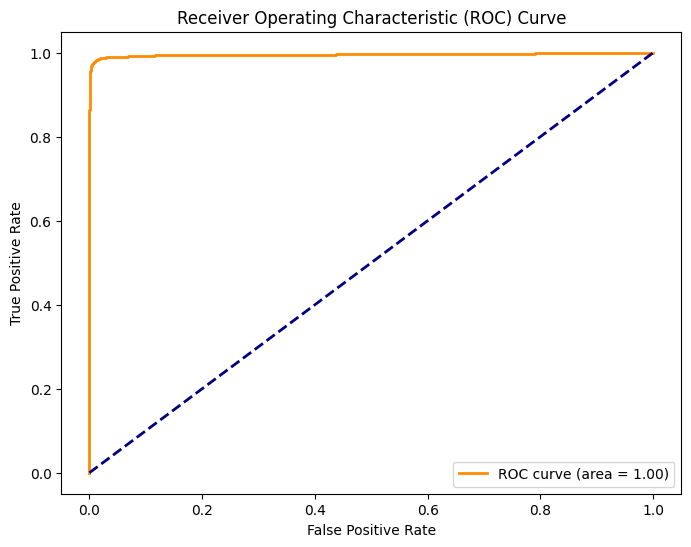

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Assuming cnn_model.predict(X_test) returns the predicted probabilities
import time

start_time = time.time()
# Make predictions on the test set
y_pred_prob = cnn_model.predict(X_test)

# Convert probabilities to binary predictions (0 or 1)
y_pred = (y_pred_prob > 0.5).astype(int)
end_time = time.time()

prediction_time_tensorflow = end_time - start_time


# Calculate and print accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy}')

# Calculate and print precision
precision = precision_score(y_test, y_pred)
print(f'Precision: {precision}')

# Calculate and print recall
recall = recall_score(y_test, y_pred)
print(f'Recall: {recall}')

# Calculate and print F1 score
f1 = f1_score(y_test, y_pred)
print(f'F1 Score: {f1}')

# Calculate ROC AUC score
roc_auc = roc_auc_score(y_test, y_pred_prob)
print(f'ROC AUC Score: {roc_auc}')

# Plot ROC curve
fpr, tpr, _ = roc_curve(y_test, y_pred_prob)
roc_auc_curve = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc_curve:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc='lower right')
plt.show()

In [ ]:
prediction_time_tensorflow

5.628326416015625

In [ ]:
import os
from tensorflow.keras.models import load_model

# Assuming model is your trained TensorFlow model
cnn_model.save('tensorflow_model.h5')

tensorflow_model_size = os.path.getsize('tensorflow_model.h5') / 1024
tensorflow_model_size

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


588.7734375

# CNN PyTorch

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import TensorDataset, DataLoader

class CNNModel(nn.Module):
    def __init__(self, input_shape):
        super(CNNModel, self).__init__()

        # Convolutional layers
        self.conv1 = nn.Conv1d(in_channels=input_shape[1], out_channels=64, kernel_size=1)
        self.relu = nn.ReLU()
        self.pool = nn.AdaptiveMaxPool1d(1)

        # Dense layers
        self.fc1 = nn.Linear(64, 64)
        self.fc2 = nn.Linear(64, 1)
        self.sigmoid = nn.Sigmoid()

    def forward(self, x):
        # Convolutional layers
        x = self.conv1(x)
        x = self.relu(x)
        x = self.pool(x)

        # Flatten before dense layers
        x = x.view(x.size(0), -1)

        # Dense layers
        x = self.fc1(x)
        x = self.relu(x)
        x = self.fc2(x)
        x = self.sigmoid(x)

        return x

# Convert data to PyTorch tensors
X_train_tensor = torch.Tensor(X_train)
y_train_tensor = torch.Tensor(y_train.values)

# Instantiate the model
# Assuming X_train shape is (num_samples, 1, combined_features_shape)
input_shape = X_train_tensor.shape[1:]
cnn_model_pt = CNNModel(input_shape)

# Define loss and optimizer
criterion_pt = nn.BCELoss()
optimizer_pt = optim.Adam(cnn_model_pt.parameters(), lr=0.001)

# Convert data to PyTorch DataLoader
train_dataset_pt = TensorDataset(X_train_tensor, y_train_tensor)
train_loader_pt = DataLoader(train_dataset_pt, batch_size=256, shuffle=True)

In [ ]:
# Train the model
start_time_pt = time.time()
num_epochs_pt = 50
for epoch in range(num_epochs_pt):
    for inputs, labels in train_loader_pt:
        optimizer_pt.zero_grad()
        outputs_pt = cnn_model_pt(inputs.permute(0, 2, 1))
        loss_pt = criterion_pt(outputs_pt, labels.view(-1, 1))
        loss_pt.backward()
        optimizer_pt.step()
    print(f'Epoch {epoch + 1}/{num_epochs_pt}, Loss: {loss_pt.item()}')
end_time_pt = time.time()
# Calculate training time
training_time_pytorch = end_time_pt - start_time_pt
print(f'Training Time (PyTorch): {training_time_pytorch} seconds')

Epoch 1/50, Loss: 17.87425422668457
Epoch 2/50, Loss: 27.436668395996094
Epoch 3/50, Loss: 21.46675682067871
Epoch 4/50, Loss: 25.092063903808594
Epoch 5/50, Loss: 16.672855377197266
Epoch 6/50, Loss: 17.864181518554688
Epoch 7/50, Loss: 17.86188316345215
Epoch 8/50, Loss: 10.719612121582031
Epoch 9/50, Loss: 19.05044174194336
Epoch 10/50, Loss: 16.668989181518555
Epoch 11/50, Loss: 15.556778907775879
Epoch 12/50, Loss: 21.431087493896484
Epoch 13/50, Loss: 21.42954444885254
Epoch 14/50, Loss: 10.714905738830566
Epoch 15/50, Loss: 17.860254287719727
Epoch 16/50, Loss: 13.102408409118652
Epoch 17/50, Loss: 14.291704177856445
Epoch 18/50, Loss: 19.04909324645996
Epoch 19/50, Loss: 19.049102783203125
Epoch 20/50, Loss: 13.101603507995605
Epoch 21/50, Loss: 21.429641723632812
Epoch 22/50, Loss: 11.906054496765137
Epoch 23/50, Loss: 14.287361145019531
Epoch 24/50, Loss: 15.478202819824219
Epoch 25/50, Loss: 22.6201114654541
Epoch 26/50, Loss: 15.478490829467773
Epoch 27/50, Loss: 16.6696453

In [ ]:
# Inference on the test set
X_test_tensor_pt = torch.Tensor(X_test)

start_time = time.time()

outputs_test_pt = cnn_model_pt(X_test_tensor_pt.permute(0, 2, 1))
y_pred_pt = (outputs_test_pt > 0.5).numpy().astype(int)

end_time = time.time()

prediction_time_tensorflow = end_time - start_time

prediction_time_tensorflow

0.17441201210021973

In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, roc_curve, auc
import matplotlib.pyplot as plt

# Evaluation on the test set
accuracy_pt = accuracy_score(y_test, y_pred_pt)
print(f'Test Accuracy (PyTorch): {accuracy_pt}')


Test Accuracy (PyTorch): 0.8316076855715242


In [ ]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate Metrics
accuracy_pt = accuracy_score(y_test, y_pred_pt)
precision_pt = precision_score(y_test, y_pred_pt)
recall_pt = recall_score(y_test, y_pred_pt)
f1_pt = f1_score(y_test, y_pred_pt)
roc_auc_pt = roc_auc_score(y_test, outputs_test_pt.detach().numpy())

# Display Metrics
print("Accuracy (PyTorch):", accuracy_pt)
print("Precision (PyTorch):", precision_pt)
print("Recall (PyTorch):", recall_pt)
print("F1 Score (PyTorch):", f1_pt)
print("ROC-AUC (PyTorch):", roc_auc_pt)

Accuracy (PyTorch): 0.8316076855715242
Precision (PyTorch): 0.6060157790927022
Recall (PyTorch): 0.9853678091801964
F1 Score (PyTorch): 0.7504770628196321
ROC-AUC (PyTorch): 0.8779418575552851


In [ ]:
import os
import torch

# Assuming model_pt is your trained PyTorch model
torch.save('CNNModel(nn.Module)', 'pytorch_model.pth')

pytorch_model_size = os.path.getsize('pytorch_model.pth') / 1024
pytorch_model_size

0.8671875